# Natural Language Processing with Disaster Tweets
[Kaggle Link](https://www.kaggle.com/competitions/nlp-getting-started/)

## Dataset Description
What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

## What should I expect the data format to be?
Each sample in the train and test set has the following information:

## The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format

## Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
# import libraries
#import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

#import statsmodels as sm
#import keras as k

nltk.download('stopwords')
nltk.download('punkt')

#spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mkhung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mkhung/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## EDA - Data Wrangling and Exploration
1. Look at data
2. Compare distribution of targets
3. Tokenize / Word Frequency Map
4. Generate WordCloud
5. Convert tweets to word vectors

In [2]:
# import data
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

### Look at Data
1. Head/tail
2. Info (count nulls, and look at data types)
3. Describe

#### Summary
'id' will not be useful for classification. 'keyword' only has a few null values. 'location' has several nulls. 'location' may not be a useful feature por predicting disaster tweets as there is no timestamp associated with it.

In [3]:
data_train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
data_train.tail(20)

,id,keyword,location,text,target
7593,10848,NaN,NaN,I just heard a really loud bang and everyone i...,0
7594,10849,NaN,NaN,A gas thing just exploded and I heard screams ...,1
7595,10850,NaN,NaN,NWS: Flash Flood Warning Continued for Shelby ...,1
7596,10851,NaN,NaN,RT @LivingSafely: #NWS issues Severe #Thunders...,1
7597,10852,NaN,NaN,#??? #?? #??? #??? MH370: Aircraft debris foun...,1
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
7602,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
data_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


### Compare distributions
While inspecting the distributions between target classes, we can draw the following conclusions
1. Classes are close to balanced
2. Keywords are not missing too many samples and should be dropped
3. Location is missing ~33% - handling unknown (drop column for now)

Portion of Non-Null Data Available
         id   keyword  location  text
target                               
0       1.0  0.995624  0.664210   1.0
1       1.0  0.987160  0.671354   1.0


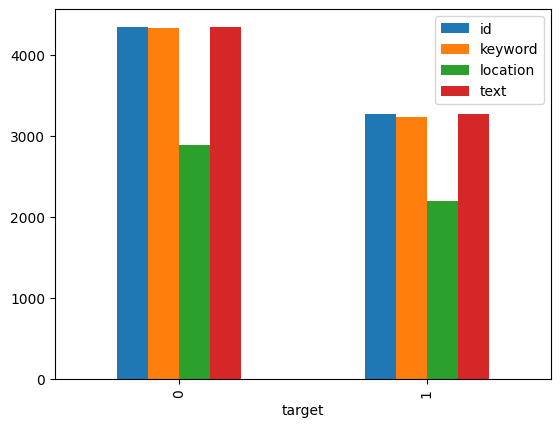

In [7]:
data_train_count = data_train.groupby('target').count()
print('Portion of Non-Null Data Available')
print(data_train_count.div(data_train_count['id'], axis=0))
data_train_count.plot.bar();

## Tokenize / Word Frequency Table with NLTK

In [8]:
# join all texts into one string
text = ' '.join(i for i in data_train.text)

# normalize and tokenize text
tokenizer = TweetTokenizer()

# https://gist.github.com/MrEliptik/b3f16179aa2f530781ef8ca9a16499af
from text_preprocessing import *
text = remove_URL(text)
words = tokenizer.tokenize(text)
words = remove_non_ascii(words)
words = to_lowercase(words)
words = remove_punctuation(words)
words = remove_stopwords(words)

# build frequency map
df_words = pd.DataFrame.from_dict(Counter(words), orient='index').rename(columns={0:'count'})
print('Unique words: %i' %len(df_words))
df_words.sort_values(by='count', ascending=False, inplace=True)
df_words

Unique words: 17390


,count
like,346
u_,343
im,303
fire,254
get,229
...,...
fnaf_talkmc,1
superstitions,1
inaechaos,1
jumper,1


## Generate WordCloud

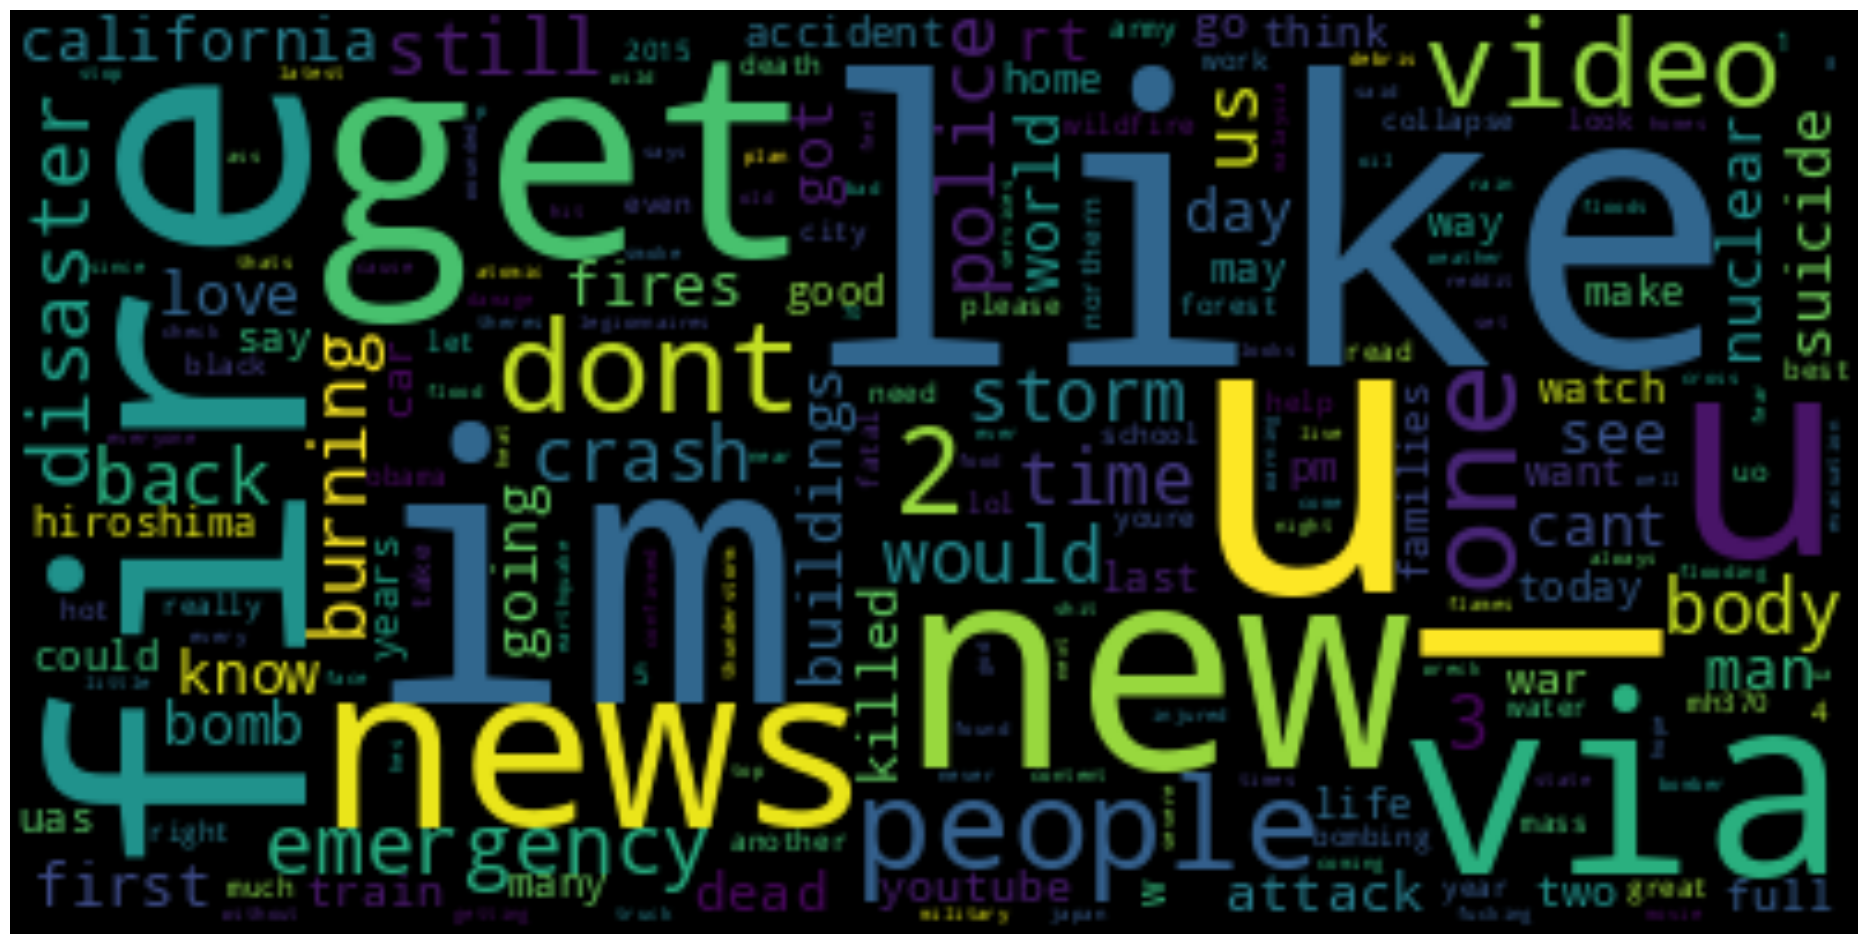

In [9]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=Counter(words))
plt.figure(figsize=(24,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Vectorize

In [10]:
# build preprocessor and tokenizer functions based on above flow
def preprocessor(text):
    text = remove_URL(text)
    return text

def custom_tokenizer(text):
    tokenizer = TweetTokenizer()
    words = tokenizer.tokenize(text)
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

vectorizer = CountVectorizer(strip_accents='ascii',
                             preprocessor=preprocessor,
                             tokenizer=custom_tokenizer,
                             stop_words = None)
df_vectors = vectorizer.fit_transform(data_train.text)

/Users/mkhung/Documents/Python/UCSD/Capstone/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
vectorizer.get_feature_names_out()[:].shape

(17389,)

In [12]:
df_counts = pd.DataFrame(df_vectors.sum(axis=0), columns=vectorizer.get_feature_names_out()).transpose().rename(columns={0:'counts'})
print(df_counts.sort_values(by='counts', ascending=False))

           counts
like          346
u_            343
im            303
fire          254
get           229
...           ...
hdumpty39       1
hea             1
headdesk        1
header          1
zzzz            1

[17389 rows x 1 columns]


In [13]:
# rows match
# df_vectors columns is close to max words
print(data_train.shape)
print(df_vectors.shape)

(7613, 5)
(7613, 17389)


## Survey of Existing Solutions

### Potential Libraries
1. fast.ai
2. spaCy
3. Flair
4. gensim
5. fastText
6. Stanford Core NLP